In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import holidays
import statsmodels.tsa as tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn import metrics as met 
from sklearn import preprocessing as pre
import warnings
warnings.filterwarnings("ignore")

In [2]:
clicks = pd.read_csv('C:\\Users\\murat.demiralay\\Downloads\\clicks.csv')
clicks['date_ymd'] = pd.to_datetime(clicks['date_ymd'], format='%Y%m%d')
clicks.set_index('date_ymd',inplace = True)
clicks.index.freq = 'D'
print(clicks.shape)
clicks.head()

(242, 1)


,click_count
date_ymd,
2019-01-01,19712
2019-01-02,22632
2019-01-03,22579
2019-01-04,20716
2019-01-05,21953


In [3]:
clicks.index

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2019-08-21', '2019-08-22', '2019-08-23', '2019-08-24',
               '2019-08-25', '2019-08-26', '2019-08-27', '2019-08-28',
               '2019-08-29', '2019-08-30'],
              dtype='datetime64[ns]', name='date_ymd', length=242, freq='D')

### Checkin missing dates 

In [4]:
pd.date_range(start = '20190101', end = '20190830' ).difference(clicks.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

No missing date found in the series

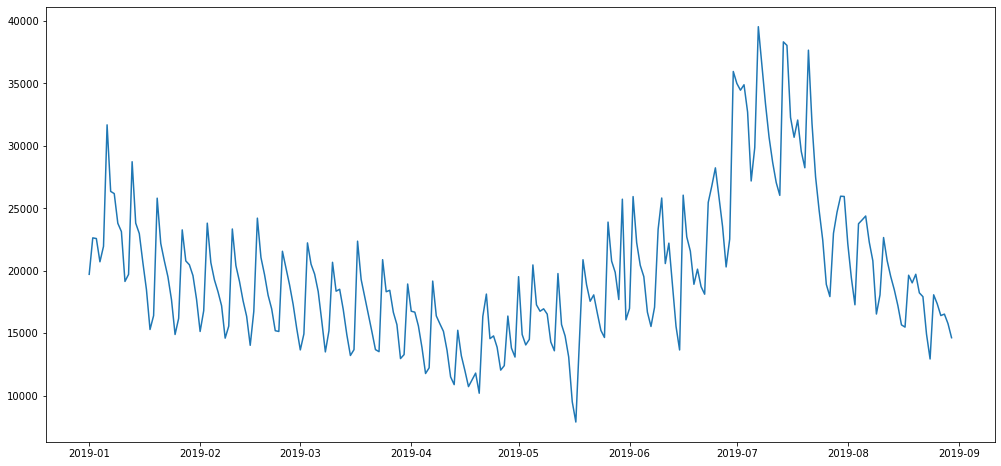

In [5]:
# Lets plot to see how it looks in generall

plt.subplots(figsize=(17,8))
plt.plot(clicks['click_count'])
plt.show()

Time series seems to be cyclic and from an decreasing trend to increasing trend then again decreasing trend. And it does not seems to be statinary.

### Seasonal Decomposition 

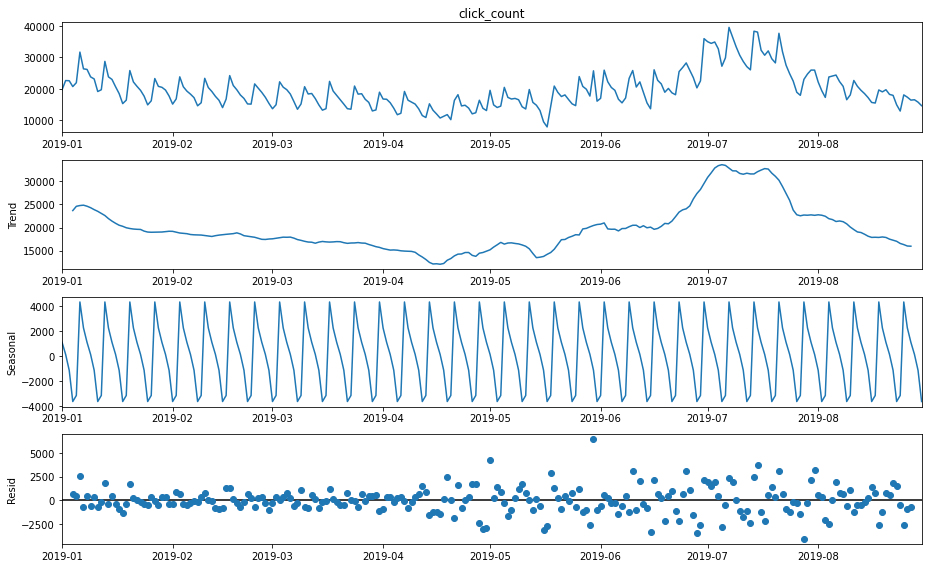

In [6]:
plt.rcParams["figure.figsize"] = (13,8)
result = tsa.seasonal.seasonal_decompose(clicks['click_count'], model='add')
result.plot();

We have a pretty clear cyclic data and it does not seems to be stationary


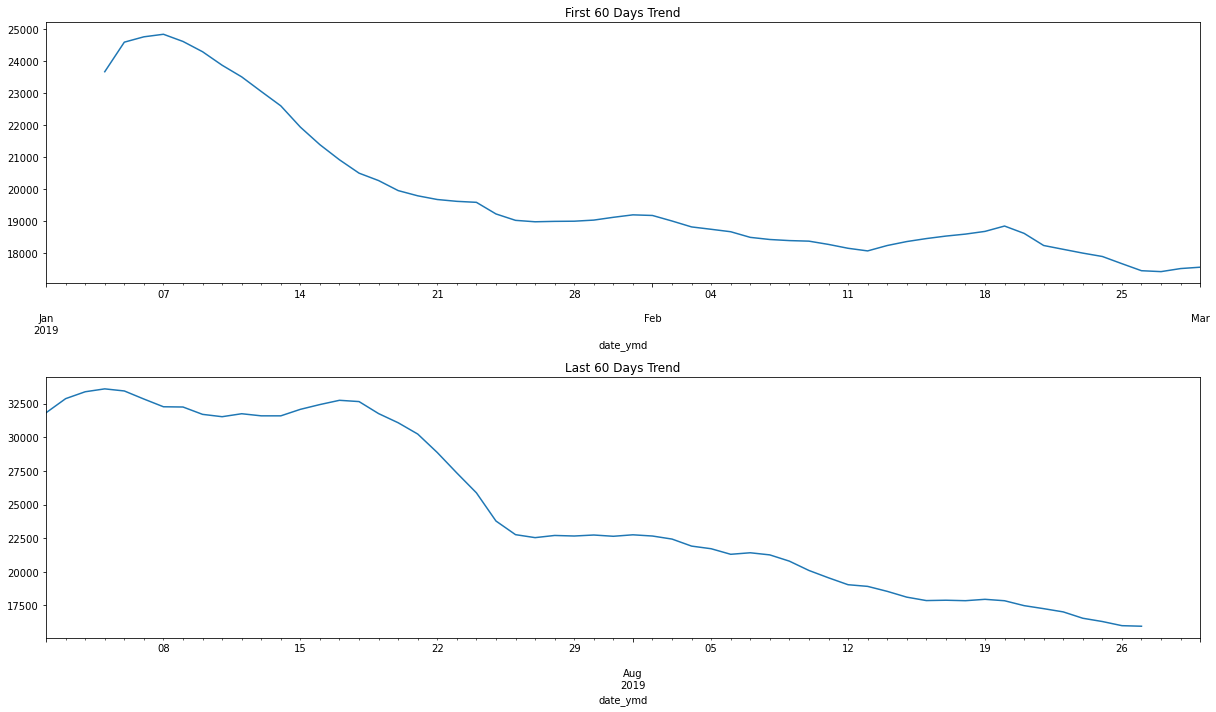

In [7]:
## Lets check first and last 60 days closer

fig, axes = plt.subplots(2,1,figsize=(17,10))
plt.subplot(2,1, 1)
result.trend[:60].plot()
plt.title('First 60 Days Trend')
plt.subplot(2,1, 2)
result.trend[-60:].plot()
plt.title("Last 60 Days Trend")
plt.tight_layout()
plt.show()

First and last 60 days seems to behave similar, and noticing there is 6 months between them.

### Checking possible Outliers

In [8]:
Q1 = np.percentile(clicks['click_count'], 25) 
Q3 = np.percentile(clicks['click_count'], 75) 
IQR = Q3 - Q1 
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
print('lower :',lower , 'upper :', upper)
print('Possible Number of Outliers For harcama Column'
      ,clicks[(clicks['click_count']<lower) | (clicks['click_count']  > upper)]['click_count'].count())

lower : 5141.375 upper : 32940.375
Possible Number of Outliers For harcama Column 10


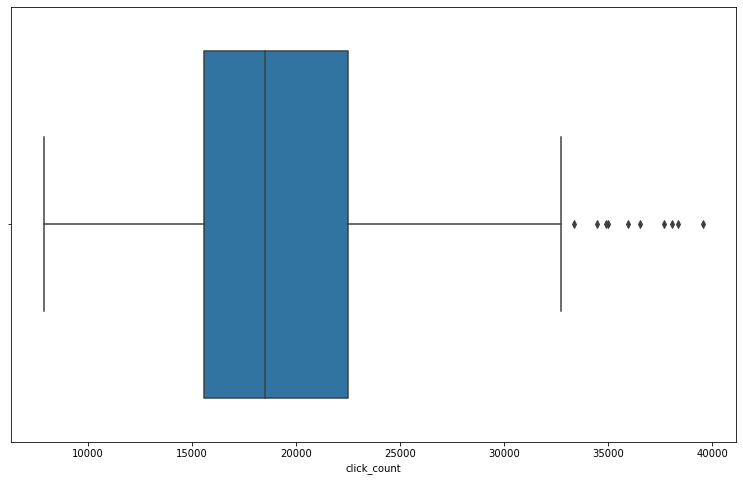

In [9]:
sns.boxplot(clicks.click_count);

In [10]:
clicks[(clicks.click_count > upper) | (clicks.click_count < lower)]

,click_count
date_ymd,
2019-06-30,35962
2019-07-01,35003
2019-07-02,34461
2019-07-03,34899
2019-07-07,39550
2019-07-08,36507
2019-07-09,33372
2019-07-14,38333
2019-07-15,38050


These 10 values might be outliers but they are not that big and many, I will leave them as they are for now.

### Stationarity check

In [11]:
result = tsa.stattools.adfuller(clicks.click_count)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.070676
p-value: 0.256468
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574


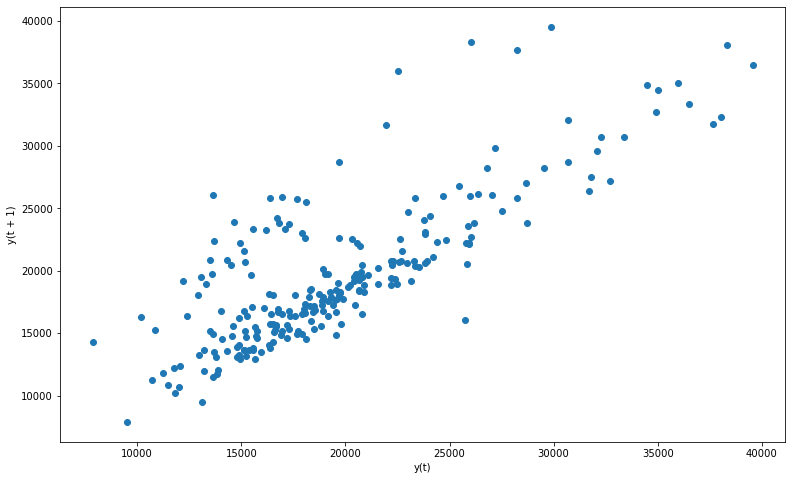

In [12]:
pd.plotting.lag_plot(clicks['click_count']);

p value is above 0.05 and ADF stats is also bigger then critical values therefore, as we saw from plots data is not stationary. Lets try to make it

### Differencing The Time Series

In [13]:
clicks['diff_1'] = tsa.statespace.tools.diff(clicks['click_count'],seasonal_periods=1)
first_value = clicks['click_count'][0]
clicks.dropna(inplace = True)
clicks.head()

,click_count,diff_1
date_ymd,,
2019-01-02,22632,2920.0
2019-01-03,22579,-53.0
2019-01-04,20716,-1863.0
2019-01-05,21953,1237.0
2019-01-06,31686,9733.0


In [14]:
## Lets run ad-fuller test again on differentiated values to see if it became stationary

result = tsa.stattools.adfuller(clicks.diff_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.599992
p-value: 0.005761
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574


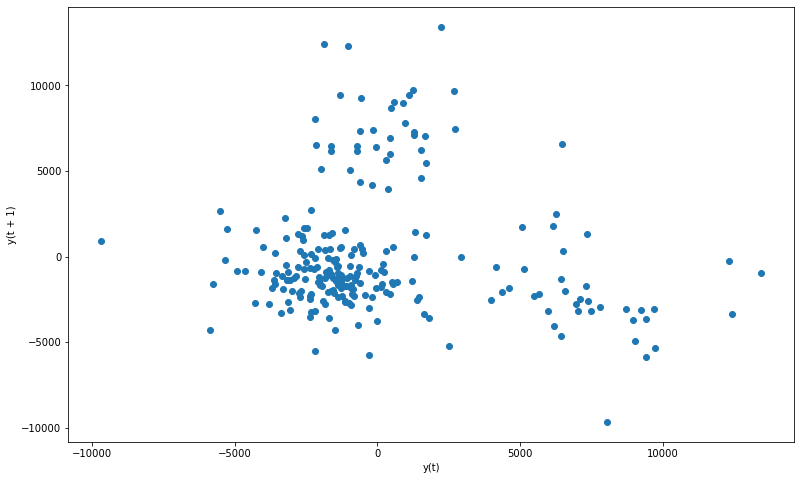

In [15]:
pd.plotting.lag_plot(clicks['diff_1']);

Time series seems to became stationary with taking season = 7 diffence

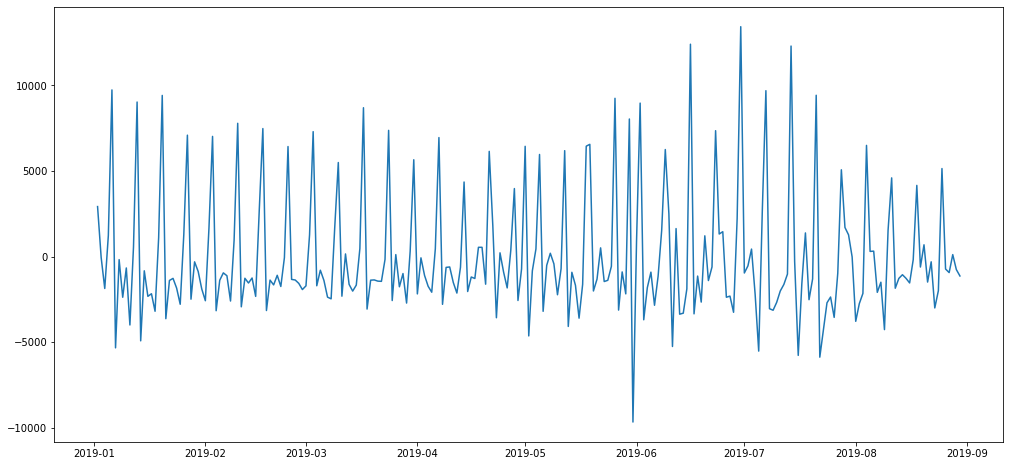

In [16]:
plt.subplots(figsize=(17,8))
plt.plot(clicks['diff_1'])
plt.show()

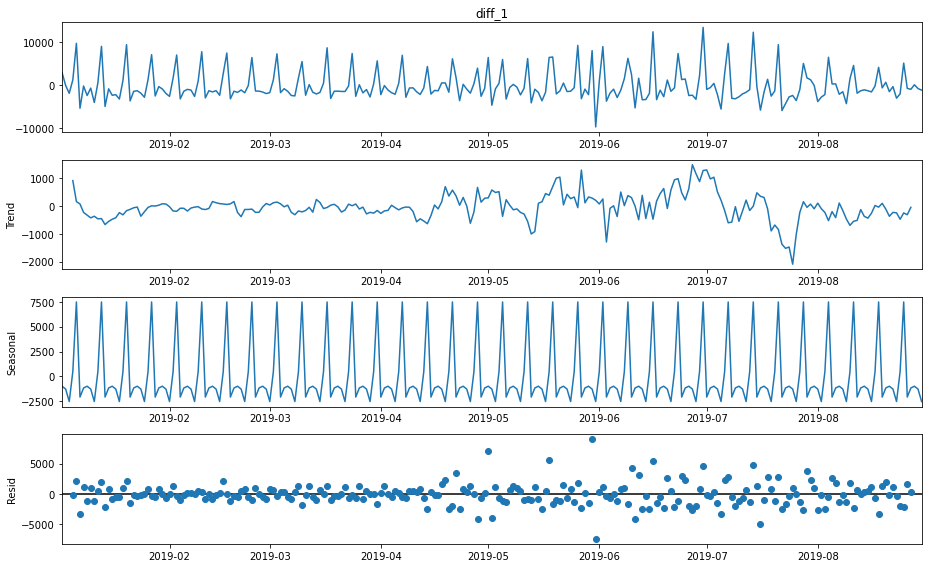

In [17]:
plt.rcParams["figure.figsize"] = (13,8)
result = tsa.seasonal.seasonal_decompose(clicks['diff_1'], model='add')
result.plot();

Eyeballing correlation between lags 

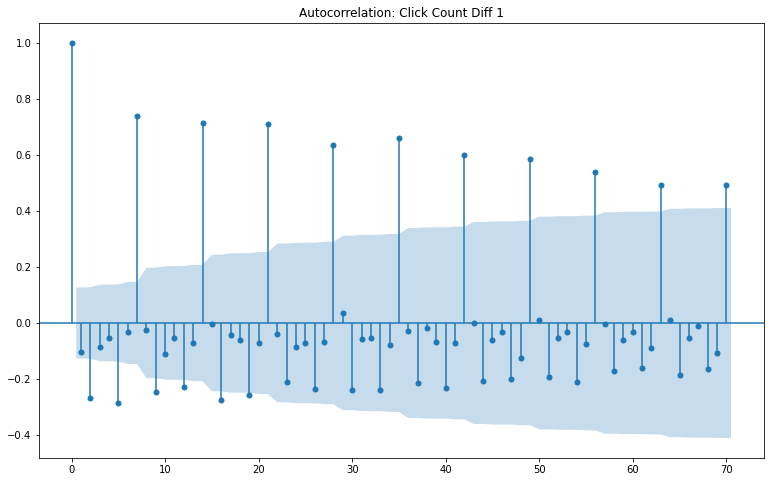

In [19]:
title = 'Autocorrelation: Click Count Diff 1'
lags = 70
plot_acf(clicks['diff_1'],title=title,lags=lags);

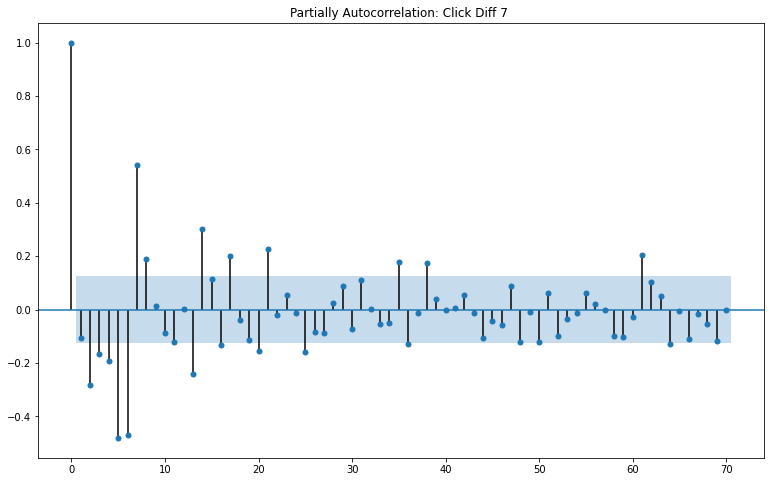

In [19]:
title = 'Partially Autocorrelation: Click Diff 7 '
lags = 70
plot_pacf(clicks['diff_7'],title=title,lags=lags);

Since both plot shows a decay after first lag, AR and MA would be used for better fitting time series. p and q might be 1 but I will use auto arima in order to get precise number. Apart from that we can see that seasonal component will be 7.

### Train - Test split 

In [17]:
prediction_period = 30
train = clicks[:-30]
test = clicks[-30:]

In [18]:
### Function for printing results 
model_list = []
mse_list = []
rmse_list = []
mae_list = []
mape_list = []

def resultScores(model_name,preds):
  ### Calculating Scores
  mse = met.mean_squared_error(test['click_count'], preds).round().astype(int)
  rmse = met.mean_squared_error(test['click_count'], preds,squared = False).round().astype(int)
  mae = met.mean_absolute_error(test['click_count'], preds).round().astype(int)
  mape = int(np.mean(np.abs((test['click_count'] - preds) / test['click_count'])) * 100)

  #Adding scores into list for future usage
  model_list.append(model_name)
  mse_list.append(mse)
  rmse_list.append(rmse)
  mae_list.append(mae)
  mape_list.append(mape)

  #printing Scores
  print('MSE  :',  mse)
  print('RMSE :', rmse)
  print('MAE  :',mae)
  print('MAPE  :',mape)

## AR model

In [18]:
model = tsa.ar_model.AR(train['diff_7'])
AR1fit = model.fit(method='mle')
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')


start=len(train)
end=len(train)+len(test)-1 
ar_predictions = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR Predictions')
ar_predictions = ar_predictions.cumsum().fillna(0) + first_value

print('=' * 30)
resultScores('AR',ar_predictions)

Lag: 14
Coefficients:
const         23.093306
L1.diff_1     -0.306716
L2.diff_1     -0.201006
L3.diff_1     -0.082907
L4.diff_1     -0.046152
L5.diff_1     -0.243072
L6.diff_1     -0.116780
L7.diff_1      0.306336
L8.diff_1      0.046024
L9.diff_1     -0.046557
L10.diff_1    -0.207528
L11.diff_1    -0.169692
L12.diff_1    -0.039455
L13.diff_1    -0.113233
L14.diff_1     0.320772
dtype: float64
MSE  : 6011736
RMSE : 2452
MAE  : 2113
MAPE  : 12


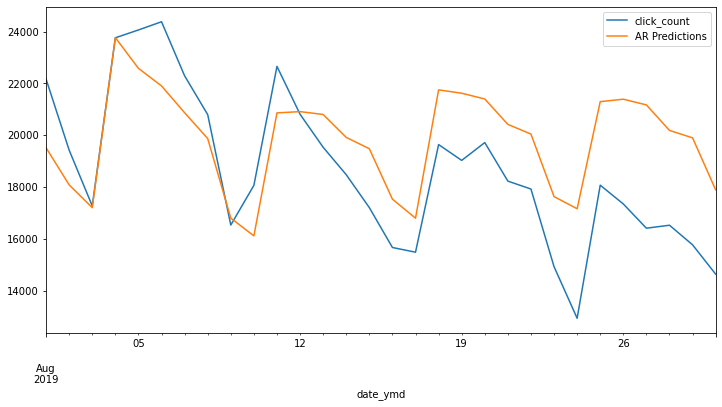

In [19]:
test['click_count'].plot(legend=True)
ar_predictions.plot(legend=True,figsize=(12,6));

Even if while Simple Exponential Smoothing seems to have better scores, AR model seems to be fitting much better to series

## MA

In [39]:
ma = tsa.holtwinters.SimpleExpSmoothing(train['diff_7']).fit(smoothing_level=1/14) 

ma_preds = ma.forecast(30).rename('Forecast')
ma_preds = ma_preds.cumsum().fillna(0) + first_value
resultScores('MA', ma_preds)

MSE  : 6120036
RMSE : 2474
MAE  : 1983
MAPE  : 10


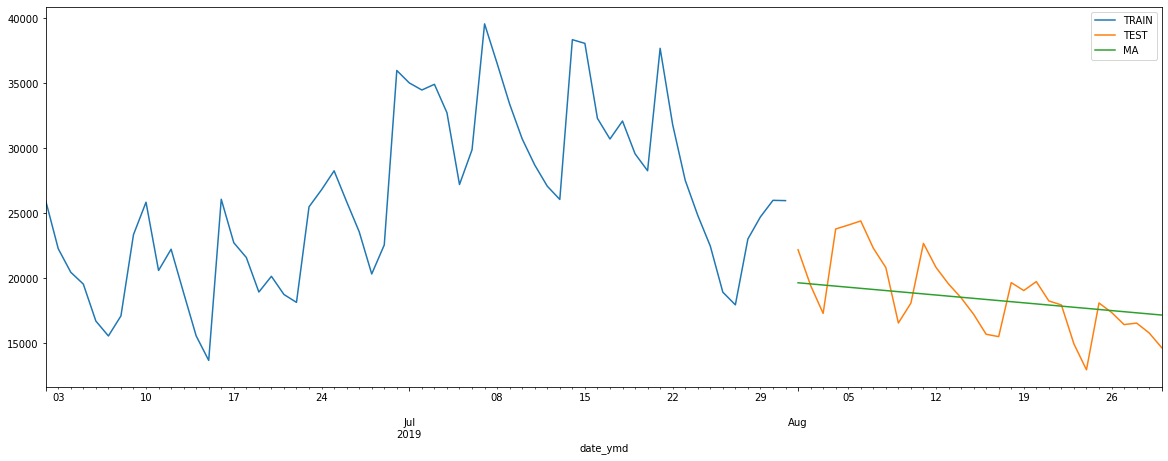

In [40]:
train['click_count'][-60:].plot(legend=True,label='TRAIN',figsize=(20,7))
test['click_count'].plot(legend=True,label='TEST',figsize=(20,7))
ma_preds.plot(legend=True,label='MA',figsize=(20,7))
plt.show()

In [41]:
 pip install pmdarima

     |████████████████████████████████| 1.5 MB 5.2 MB/s 
     |████████████████████████████████| 9.5 MB 24.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


## ARMA with auto arima

In [42]:
from pmdarima import auto_arima
step_wise = auto_arima(train['diff_7'], start_p=1, start_q =1,max_P=10,max_q = 10,seasonal=False,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4044.854, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4078.215, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4077.532, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4071.767, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4036.035, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4061.950, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4037.162, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4038.541, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4058.812, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4038.206, Time=0.06 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 0.957 seconds


In [43]:
model = tsa.arima_model.ARIMA(train['diff_7'],order=(2,0,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 diff_7   No. Observations:                  211
Model:                     ARMA(2, 1)   Log Likelihood               -2013.093
Method:                       css-mle   S.D. of innovations           3361.081
Date:                Tue, 14 Sep 2021   AIC                           4036.187
Time:                        17:00:27   BIC                           4052.946
Sample:                    01-02-2019   HQIC                          4042.961
                         - 07-31-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           12.1155     65.288      0.186      0.853    -115.847     140.078
ar.L1.diff_7     0.4768      0.081      5.904      0.000       0.319       0.635
ar.L2.diff_7    -0.2481      0.072     -3.465      0.001      -0.388      -0.108
ma.L1.diff_7    -0.7863      0.054    -14.450      0.000      -0.893      -0.680
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9611           -1.7628j            2.0078           -0.1706
AR.2            0.9611           +1.7628j            2.0078            0.1706
MA.1            1.2717           +0.0000j            1.2717            0.0000
-----------------------------------------------------------------------------
"""

In [44]:
start=len(train)
end=len(train)+len(test)-1 
arima_predictions = results.predict(start=start, end=end).rename('ARIMA')

arima_predictions = arima_predictions.cumsum().fillna(0) + first_value
resultScores('ARMA',arima_predictions)

MSE  : 8898863
RMSE : 2983
MAE  : 2467
MAPE  : 13


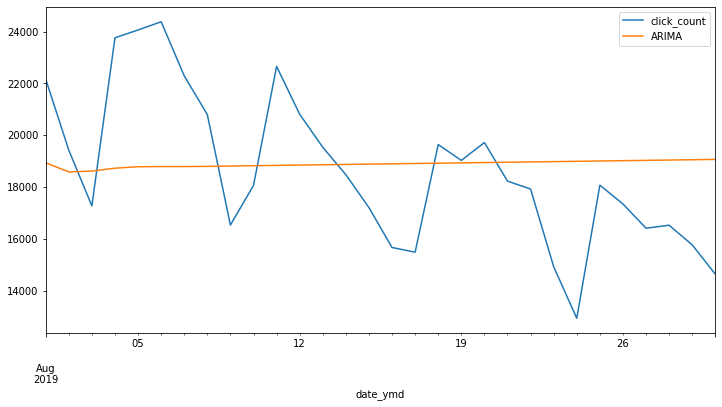

In [45]:
test['click_count'].plot(legend=True)
arima_predictions.plot(legend=True,figsize=(12,6));

## SARMA - with auto arima  

In [46]:
auto_arima(train['diff_7'], start_p=1, start_q =1,max_P=10,max_q = 10, m=7,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=4080.202, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=3896.065, Time=0.59 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=3983.168, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=4078.215, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=4079.520, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=3858.922, Time=2.14 sec
 ARIMA(1,0,0)(3,0,0)[7] intercept   : AIC=inf, Time=5.06 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=3874.862, Time=1.71 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=3860.292, Time=0.78 sec
 ARIMA(1,0,0)(3,0,1)[7] intercept   : AIC=3855.130, Time=3.81 sec
 ARIMA(1,0,0)(4,0,1)[7] intercept   : AIC=3856.507, Time=6.70 sec
 ARIMA(1,0,0)(3,0,2)[7] intercept   : AIC=inf, Time=3.29 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=3.01 sec
 ARIMA(1,0,0)(4,0,0)[7] intercept   : AIC=inf, Time=5

ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(3, 0, 1, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [47]:
model = tsa.statespace.sarimax.SARIMAX(train['diff_7'],order=(1,0,0), seasonal_order=(3,0,1,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                            diff_7   No. Observations:                  211
Model:             SARIMAX(1, 0, 0)x(3, 0, 1, 7)   Log Likelihood               -1904.703
Date:                           Tue, 14 Sep 2021   AIC                           3821.406
Time:                                   17:01:58   BIC                           3841.517
Sample:                               01-02-2019   HQIC                          3829.535
                                    - 07-31-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2272      0.047     -4.829      0.000      -0.319      -0.135
ar.S.L7        1.0632      0.082     12.926      0.000       0.902       1.224
ar.S.L14       0.0176      0.095      0.186      0.853      -0.168       0.203
ar.S.L21      -0.0811      0.062     -1.303      0.192      -0.203       0.041
ma.S.L7       -0.9663      0.066    -14.750      0.000      -1.095      -0.838
sigma2       3.62e+06   2.56e-08   1.41e+14      0.000    3.62e+06    3.62e+06
===================================================================================
Ljung-Box (Q):                       57.37   Jarque-Bera (JB):               190.61
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               5.12   Skew:                             1.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.68e+29. Standard errors may be unstable.
"""

In [48]:
start=len(train)
end=len(train)+len(test)-1 
sarima_preds = results.predict(start=start, end=end, dynamic=False).rename('SARIMA Predictions')

sarima_preds = sarima_preds.cumsum().fillna(0) + first_value
resultScores('SARMA',sarima_preds)

MSE  : 7722873
RMSE : 2779
MAE  : 2294
MAPE  : 12


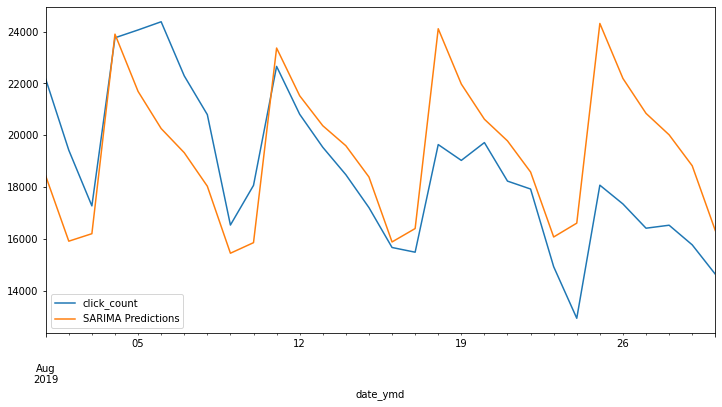

In [49]:
test['click_count'].plot(legend=True)
sarima_preds.plot(legend=True,figsize=(12,6));

I will use daily temprature data of Oslo as exog variable for SARIMAX

In [50]:
daily_tempt = pd.read_csv('/content/drive/MyDrive/trivago/oslo_daily_temprature.csv')
daily_tempt['date'] = pd.to_datetime(daily_tempt['date'])
daily_tempt.set_index('date',inplace = True)
daily_tempt.head()

,max,mean,min
date,,,
2019-01-01,6.0,3.7,1.0
2019-01-02,1.0,-0.8,-2.0
2019-01-03,3.0,0.2,-2.0
2019-01-04,5.0,1.2,-3.0
2019-01-05,2.0,-0.7,-6.0


In [51]:
train = train.merge(daily_tempt,how='left',left_index= True,right_index=True)
test = test.merge(daily_tempt,how='left',left_index= True,right_index=True)

### Causality Check

In [52]:
tsa.stattools.grangercausalitytests(train[['click_count','mean']],maxlag=7);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8896  , p=0.0093  , df_denom=207, df_num=1
ssr based chi2 test:   chi2=6.9894  , p=0.0082  , df=1
likelihood ratio test: chi2=6.8756  , p=0.0087  , df=1
parameter F test:         F=6.8896  , p=0.0093  , df_denom=207, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5572  , p=0.0303  , df_denom=204, df_num=2
ssr based chi2 test:   chi2=7.2887  , p=0.0261  , df=2
likelihood ratio test: chi2=7.1645  , p=0.0278  , df=2
parameter F test:         F=3.5572  , p=0.0303  , df_denom=204, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9938  , p=0.1161  , df_denom=201, df_num=3
ssr based chi2 test:   chi2=6.1898  , p=0.1027  , df=3
likelihood ratio test: chi2=6.0995  , p=0.1069  , df=3
parameter F test:         F=1.9938  , p=0.1161  , df_denom=201, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4053  , p=0.2336  

From causality test we can see that click counts seems to be effected by temprature

### SARIMA X with temperature 

In [53]:
scaler = pre.MinMaxScaler()
exog_train = scaler.fit_transform(train[['mean']])
exog_test = scaler.transform(test[['mean']])

In [54]:
auto_arima(train['diff_7'], X = exog_train, start_p=1, start_q =1, max_P=10, max_q = 10, m=7 ,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=4082.180, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=3898.073, Time=0.60 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=3985.125, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=4080.253, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=4081.482, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=3860.889, Time=2.32 sec
 ARIMA(1,0,0)(3,0,0)[7] intercept   : AIC=inf, Time=5.61 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=3879.734, Time=2.18 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=3899.245, Time=1.00 sec
 ARIMA(1,0,0)(3,0,1)[7] intercept   : AIC=3856.995, Time=4.61 sec
 ARIMA(1,0,0)(4,0,1)[7] intercept   : AIC=3856.945, Time=8.24 sec
 ARIMA(1,0,0)(4,0,0)[7] intercept   : AIC=inf, Time=7.03 sec
 ARIMA(1,0,0)(5,0,1)[7] intercept   : AIC=3852.084, Time=12.39 sec
 ARIMA(1,0,0)(5,0,0)[7] intercept   : AIC=inf, 

ARIMA(maxiter=50, method='lbfgs', order=(3, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(6, 0, 1, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [55]:
model = tsa.statespace.sarimax.SARIMAX(train['diff_7'] ,exog=exog_train,order=(3,0,0), seasonal_order=(6,0,1,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                            diff_7   No. Observations:                  211
Model:             SARIMAX(3, 0, 0)x(6, 0, 1, 7)   Log Likelihood               -1955.837
Date:                           Tue, 14 Sep 2021   AIC                           3935.675
Time:                                   17:13:47   BIC                           3975.897
Sample:                               01-02-2019   HQIC                          3951.933
                                    - 07-31-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            81.2516   2127.969      0.038      0.970   -4089.491    4251.994
ar.L1         -0.2745      0.160     -1.719      0.086      -0.588       0.039
ar.L2         -0.0110      0.246     -0.045      0.964      -0.494       0.472
ar.L3         -0.0902      0.207     -0.436      0.663      -0.496       0.316
ar.S.L7        1.3159      0.341      3.859      0.000       0.648       1.984
ar.S.L14      -0.2064      0.295     -0.699      0.485      -0.785       0.373
ar.S.L21      -0.0986      0.309     -0.320      0.749      -0.703       0.506
ar.S.L28       0.0434      0.335      0.130      0.897      -0.612       0.699
ar.S.L35       0.1349      0.361      0.374      0.709      -0.573       0.842
ar.S.L42      -0.1900      0.277     -0.686      0.493      -0.733       0.353
ma.S.L7       -0.9765      0.372     -2.628      0.009      -1.705      -0.248
sigma2      1.215e+07      0.216   5.63e+07      0.000    1.22e+07    1.22e+07
===================================================================================
Ljung-Box (Q):                       70.85   Jarque-Bera (JB):               125.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.60   Skew:                             1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.42e+24. Standard errors may be unstable.
"""

In [56]:
start=len(train)
end=len(train)+len(test)-1
sarimax_preds = results.predict(start=start, end=end, exog=exog_test, dynamic=False).rename('SARIMAX Predictions')

sarimax_preds = sarimax_preds.cumsum().fillna(0) + first_value
resultScores('SARMAX',sarimax_preds)

MSE  : 6354281
RMSE : 2521
MAE  : 2006
MAPE  : 10


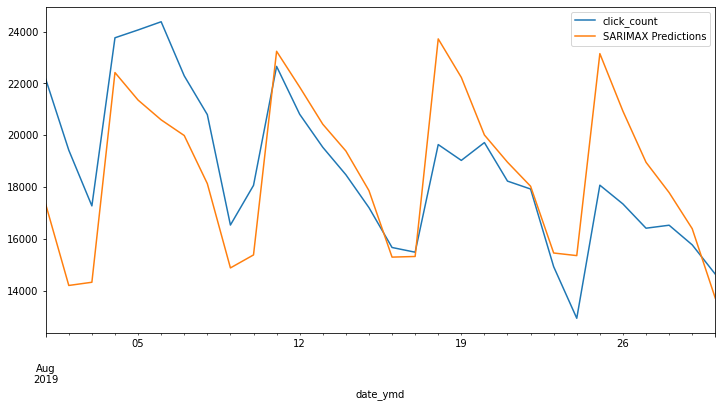

In [57]:
test['click_count'].plot(legend=True)
sarimax_preds.plot(legend=True,figsize=(12,6));

CNN

In [ ]:
train, test = np.array(df[:-30]), np.array(df[-30:])
train= train.reshape(-1,1)
test= test.reshape(-1,1)

In [ ]:
scaler = pre.MinMaxScaler()
scaler.fit(train['diff_1'].values.reshape(-1, 1))
scaled_train = scaler.transform(train['diff_1'].values.reshape(-1, 1))
scaled_test = scaler.transform(test['diff_1'].values.reshape(-1, 1))

## LSTM

In [15]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [19]:
scaler = pre.MinMaxScaler()
scaler.fit(train['diff_1'].values.reshape(-1, 1))
scaled_train = scaler.transform(train['diff_1'].values.reshape(-1, 1))
scaled_test = scaler.transform(test['diff_1'].values.reshape(-1, 1))

In [20]:
# define generator
n_input = 14
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [21]:
early_stop = EarlyStopping(monitor='val_loss',patience=20)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=29, batch_size=1)

In [44]:
# define model
lstm_model = Sequential(name='LSTM')
lstm_model.add((LSTM(32, activation='relu', input_shape=(n_input, n_features))))
lstm_model.add(Dense(8))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
#lstm_model.summary()

In [45]:
lstm_model.fit_generator(generator,epochs=200,validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/200
197/197 [==============================] - 2s 4ms/step - loss: 0.0429 - val_loss: 0.0023
Epoch 2/200
197/197 [==============================] - 1s 3ms/step - loss: 0.0293 - val_loss: 0.0089
Epoch 3/200
197/197 [==============================] - 1s 3ms/step - loss: 0.0273 - val_loss: 4.9195e-04
Epoch 4/200
197/197 [==============================] - 1s 3ms/step - loss: 0.0285 - val_loss: 0.0031
Epoch 5/200
197/197 [==============================] - 1s 3ms/step - loss: 0.0273 - val_loss: 0.0022
Epoch 6/200
197/197 [==============================] - 1s 3ms/step - loss: 0.0273 - val_loss: 0.0029
Epoch 7/200
197/197 [==============================] - 1s 3ms/step - loss: 0.0273 - val_loss: 0.0041
Epoch 8/200
197/197 [==============================] - 1s 3ms/step - loss: 0.0264 - val_loss: 0.0110
Epoch 9/200
197/197 [==============================] - 1s 3ms/step - loss: 0.0276 - val_loss: 0.0055
Epoch 10/200
197/197 [==============================] - 1s 3ms/step - loss: 0.0269 - va

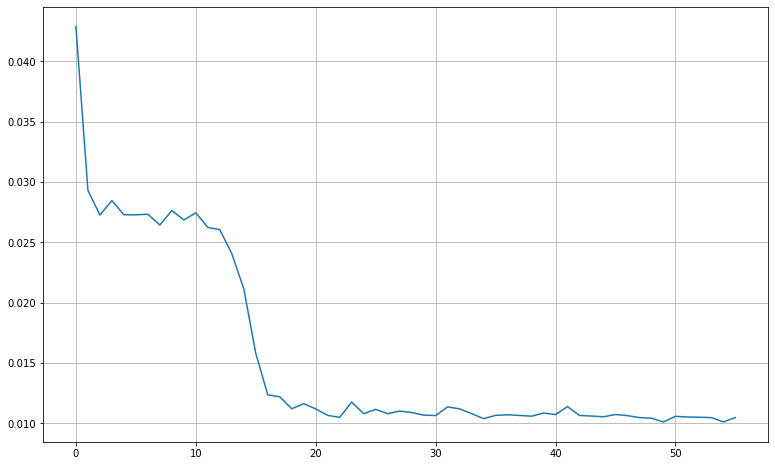

In [46]:
loss_per_epoch = lstm_model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.grid()
plt.show;

In [43]:
lstm_preds = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = lstm_model.predict(current_batch)[0]
    # store prediction
    lstm_preds.append(current_pred[0]) 

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

lstm_preds = np.array(lstm_preds).cumsum() + first_value
resultScores('LSTM',lstm_preds)

MSE  : 9615270
RMSE : 3101
MAE  : 2610
MAPE  : 14


In [32]:
pd.DataFrame([mse_list,rmse_list,mae_list,mape_list], index= ['MSE','RMSE','MAE','MAPE'],columns=model_list)

,LSTM,LSTM
MSE,9614337,9612103
RMSE,3101,3100
MAE,2610,2609
MAPE,14,14


### Final Prediction with SARMAX

In [ ]:
clicks = clicks.merge(daily_tempt,how='left',left_index= True,right_index=True)

scaler = pre.MinMaxScaler()
exog_data = scaler.fit_transform(clicks[['mean']])
exog_pred = scaler.transform(daily_tempt[(daily_tempt.index >= '2019-08-31')&(daily_tempt.index <= '2019-09-30')][['mean']])

In [89]:
final_model = tsa.statespace.sarimax.SARIMAX(clicks['diff_7'],exog =exog_data ,order=(3,0,0), seasonal_order=(6,0,1,7), enforce_invertibility=False)
results = final_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                            diff_7   No. Observations:                  241
Model:             SARIMAX(3, 0, 0)x(6, 0, 1, 7)   Log Likelihood               -2226.074
Date:                           Tue, 14 Sep 2021   AIC                           4476.148
Time:                                   17:29:34   BIC                           4517.965
Sample:                               01-02-2019   HQIC                          4492.995
                                    - 08-30-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -35.5669   1756.234     -0.020      0.984   -3477.722    3406.588
ar.L1         -0.2419      0.150     -1.614      0.107      -0.536       0.052
ar.L2         -0.1503      0.233     -0.645      0.519      -0.607       0.307
ar.L3         -0.1147      0.214     -0.536      0.592      -0.534       0.305
ar.S.L7        1.2161      0.678      1.793      0.073      -0.113       2.546
ar.S.L14      -0.0461      0.338     -0.137      0.891      -0.708       0.616
ar.S.L21      -0.0039      0.315     -0.013      0.990      -0.621       0.613
ar.S.L28      -0.1664      0.367     -0.454      0.650      -0.885       0.552
ar.S.L35       0.1377      0.344      0.400      0.689      -0.536       0.812
ar.S.L42      -0.1399      0.290     -0.482      0.630      -0.709       0.429
ma.S.L7       -0.9688      0.673     -1.440      0.150      -2.287       0.349
sigma2      1.187e+07      0.318   3.73e+07      0.000    1.19e+07    1.19e+07
===================================================================================
Ljung-Box (Q):                       47.14   Jarque-Bera (JB):               148.79
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               2.46   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.36e+25. Standard errors may be unstable.
"""

In [100]:
forecast = results.predict(len(clicks)-15,len(clicks)+30, exog = exog_pred, dynamic=False).rename('Forecast')
forecast = forecast.cumsum().fillna(0) + first_value

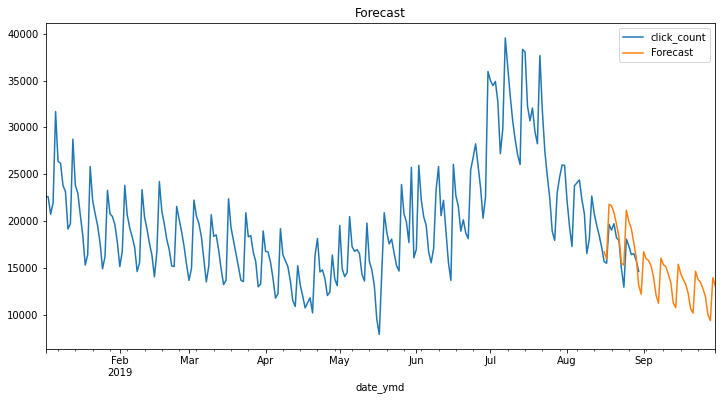

In [101]:
ax = clicks['click_count'].plot(legend=True,figsize=(12,6),title='Forecast')
forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
plt.show()

In [136]:
final_preds = pd.DataFrame(forecast[-30:])
final_preds.reset_index(inplace=True)
final_preds.rename(columns = {'index':'date_ymd', 'Forecast':'click_count'},inplace=True)
final_preds['date_ymd'] = final_preds.date_ymd.apply(lambda x: x.strftime('%Y%m%d')).astype(int)
final_preds.to_csv('clicks_september_predictions.csv',index = False)
final_preds.head()

,date_ymd,click_count
0,20190901,16703.949457
1,20190902,15980.716124
2,20190903,15778.180863
3,20190904,15207.189961
4,20190905,14007.354679
